# Autoencoder - Semi-supervised Learning

Date: 13/10/2018

Version: 1.0

Environment: R and Jupyter notebook


### Load libraries

In [1]:
library(magrittr)
library(tidyverse)
library(ggplot2)
library(reshape2)
library(h2o)

### Initialise a h2o instance

In [2]:

options(warn=-1)
#If there is a proxy: proxy.old <- Sys.getenv('http_proxy'); Sys.setenv('http_proxy'='');
localH2O =  h2o.init(nthreads = -1, port = 54321, max_mem_size = '6G', startH2O = TRUE)



----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit http://docs.h2o.ai

----------------------------------------------------------------------


Attaching package: ‘h2o’

The following objects are masked from ‘package:stats’:

    cor, sd, var

The following objects are masked from ‘package:base’:

    &&, %*%, %in%, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc



 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         50 minutes 56 seconds 
    H2O cluster timezone:       Australia/Melbourne 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.20.0.8 
    H2O cluster version age:    22 days  
    H2O cluster name:           H2O_started_from_R_tinghsu_iwm056 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   5.93 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         XGBoost, Algos, AutoML, Core V3, Core V4 
    R Version:                  R version 3.4.1 (2017-06-30) 



### Load data

In [3]:
folder <- '/Users/tinghsu/Desktop/Monash/FIT5201 Algo/Assignment2'

# use absolute path to load file
labeled.frame <- h2o.importFile(path = paste0(folder, '/assignment2_datasets/Task2C_labeled.csv') ,sep=',') 
unlabeled.frame <- h2o.importFile(path = paste0(folder, '/assignment2_datasets/Task2C_unlabeled.csv') ,sep=',') 
test.frame <- h2o.importFile(path = paste0(folder, '/assignment2_datasets/Task2C_test.csv') ,sep=',') 

labeled.frame[,1] <- as.factor(labeled.frame$label)
unlabeled.frame[,1] <- NA

# create training set and testing set 
train.frame <- h2o.rbind(labeled.frame[,-1], unlabeled.frame[,-1]) #(450,784)
test.frame[,1] <- as.factor(test.frame$label)


  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


### Build augmented self-taught networks 
Build an autoencoder  with only one hidden layer and change the number of its neurons to: 20, 40, 60, 80, .., 500 (i.e. from 20 to 500 with a step size of 20).

1. Add the output of the middle layer as extra features to the original feature set, 
2. Train a 3-layer NN (similar to Step IV) using all features (original + extra).
    

In [6]:
####################### GENERAL AUXILIARY FUNCTIONS #######################
## The following structure helps us to have functions with multiple outputs
### credit: https://stat.ethz.ch/pipermail/r-help/2004-June/053343.html

error.rate <- function(Y1, T1){
  if (nrow(Y1)!=nrow(T1)){
    stop('error.rate: size of true lables and predicted labels mismatch')
  }
  return (sum(T1!=Y1)/nrow(T1))
}


### empty matrix to store errors 
reconstruction.train.error <- matrix(NA, nrow=25, ncol=1)
classification.labeled.error <- matrix(NA, nrow=25, ncol=1)


reconstruction.test.error <- matrix(NA, nrow=25, ncol=1) # only calculate it to see what happens, will not use it later
classification.test.error <- matrix(NA, nrow=25, ncol=1)

counter <- 1

for (k in seq(20, 500, 20)){
    
    ### autoencoder 
    autoencoder <- h2o.deeplearning(
        x = 1:ncol(train.frame), # select all pixels
        training_frame = train.frame, # specify the frame (imported file)    
        ## replace with k in the loop
        hidden = c(k), # number of layers and their units
        epochs = 100, # maximum number of epoches  
        activation = 'Tanh', # activation function 
        autoencoder = TRUE  # is it an autoencoder? Yes!
    )
    
    # extract feature + turn into h2o
    features <- h2o.deepfeatures(autoencoder, labeled.frame, layer = 1)
    feature_list <- features %>% as.data.frame %>% as.h2o 
    new.labeled.frame <- h2o.cbind(labeled.frame, feature_list)
    
    ### 3-layer NN model 
    nn.model <- h2o.deeplearning(    
          x = 2:ncol(new.labeled.frame), # select all pixels + extra features
          y = 1,
          training_frame = new.labeled.frame, # specify the frame (imported file)    
          hidden = c(100), # number of layers and their units
          epochs = 50, # maximum number of epoches  
          activation = 'Tanh', # activation function 
          autoencoder = F, 
          l2 = 0.2 # L2 regularisation 
    )
    
    
    ### record reconstruction error
    # train
    reconstruction.train.error[counter,] <- mean(h2o.anomaly(autoencoder, train.frame))

    # test
    reconstruction.test.error[counter,] <- mean(h2o.anomaly(autoencoder, test.frame))

    ### record classification error
    # train
    labeled.predict <- h2o.predict(nn.model, labeled.frame)$predict
    classification.labeled.error[counter,] <- error.rate(labeled.frame$label, labeled.predict)

    # test
    test.predict <- h2o.predict(nn.model, test.frame)$predict
    classification.test.error[counter,] <- error.rate(test.frame$label, test.predict)

    
    counter <- counter + 1
  
}



  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

In [138]:
# combine classfication errors 
classification.error <- cbind(classification.labeled.error, classification.test.error) %>% as.data.frame() %>% mutate(seq(20,500,20))
colnames(classification.error) <- c('Train','Test', 'k') 
classification.error.m <- melt(classification.error, id.vars = 'k')

In [145]:
## lowest test classificaiton error
classification.error[which.min(classification.error$Test),]

## lowest test reconstruction error
reconstruction.error[which.min(reconstruction.error$Train),]

,Train,Test,k
9,0.06,0.464,180


,Train,Test,k
19,0.002371444,0.03067365,380


In [146]:
# combine classfication errors and reconstruction error
test.error.all <- as.data.frame(cbind(classification.error$k, classification.error$Test, classification.error$Train, reconstruction.error$Train))
colnames(test.error.all) <- c('k', 'classification.test', 'classification.train','reconstruction')

# reshape for visualisation
test.error.all.m <- melt(test.error.all, id.vars = 'k') 
colnames(test.error.all.m) <- c('k', 'Type', 'Error')

In [147]:
## order by misclassification testing error. smallest first.

test.error.all[order(test.error.all$classification.test),]

,k,classification.test,classification.train,reconstruction
9,180,0.464,0.06,0.004271262
22,440,0.478,0.08,0.002869158
24,480,0.495,0.08,0.002782238
16,320,0.503,0.06,0.002593859
23,460,0.503,0.20,0.002890748
8,160,0.505,0.08,0.005127519
18,360,0.517,0.10,0.002776240
19,380,0.521,0.10,0.002371444
13,260,0.527,0.04,0.002808322
10,200,0.539,0.12,0.003504294


In [144]:
## order by reconstruction error. smallest first.
test.error.all[order(test.error.all$reconstruction),]

,k,classification.test,classification.train,reconstruction
19,380,0.521,0.10,0.002371444
20,400,0.563,0.06,0.002391454
16,320,0.503,0.06,0.002593859
14,280,0.555,0.16,0.002650103
17,340,0.648,0.14,0.002659837
21,420,0.619,0.06,0.002728844
15,300,0.552,0.08,0.002753491
25,500,0.544,0.14,0.002762522
18,360,0.517,0.10,0.002776240
24,480,0.495,0.08,0.002782238


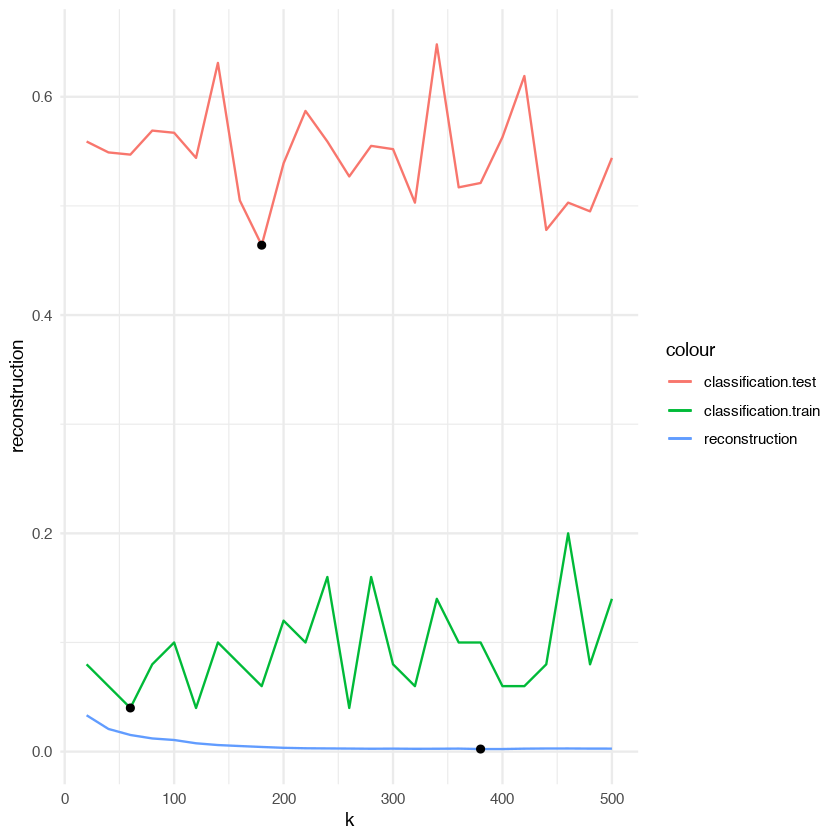

In [148]:
### visualise classfication errors and reconstruction error

ggplot(data = test.error.all) +
geom_line(data = test.error.all, aes(x = k, y = reconstruction, color = 'reconstruction')) +
geom_line(data = test.error.all, aes(x = k, y = classification.test, color = 'classification.test')) +
geom_line(data = test.error.all, aes(x = k, y = classification.train, color = 'classification.train')) +
geom_point(data = test.error.all[which.min(test.error.all$reconstruction),], aes(x = k, y = reconstruction)) +
geom_point(data = test.error.all[which.min(test.error.all$classification.train),], aes(x = k, y = classification.train)) +
geom_point(data = test.error.all[which.min(test.error.all$classification.test),], aes(x = k, y = classification.test)) +
theme_minimal()

### Calculate and record the reconstruction error of the autoencoder

Reconstruction erros is the average of Euclidian distances between the input and output of the autoencoder

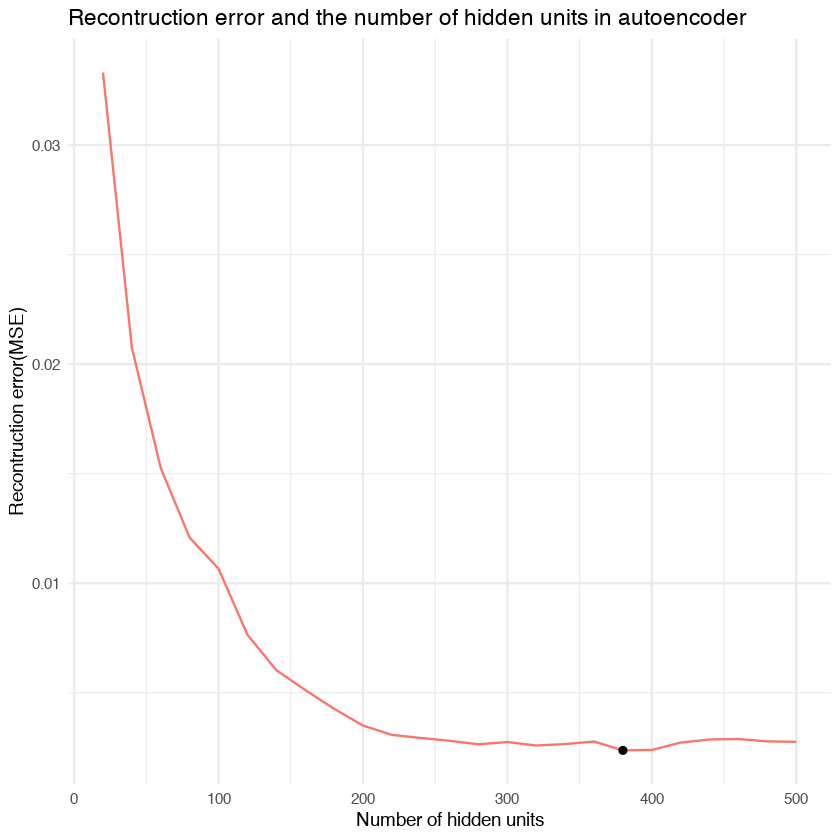

In [81]:
ggplot(data = test.error.all) +
geom_line(data = test.error.all, aes(x = k, y = reconstruction, color = 'r')) +
geom_point(data = test.error.all[which.min(test.error.all$reconstruction),], aes(x = k, y = reconstruction)) +
ggtitle('Recontruction error and the number of hidden units in autoencoder') + 
ylab('Recontruction error(MSE)') + 
xlab('Number of hidden units') + 
guides(color=F) +
theme_minimal()

### Build a 3-layer NN classification model with 100 units in the hidden layer 
Use all the original attributes from the training set. Next, calculate and record the test error.

In [4]:

# build a neural network classifier based on the labeled training data
NN.model <- h2o.deeplearning(    
  x = 2:ncol(labeled.frame), # select all pixels + extra features
  y = 1,
  training_frame = labeled.frame, # specify the frame (imported file)    
  hidden = c(100), # number of layers and their units
  epochs = 50, # maximum number of epoches  
  activation = 'Tanh', # activation function 
  autoencoder = F, 
  l2 = 0.1
)

labeled.predict <- h2o.predict(NN.model, labeled.frame)$predict
error.rate(labeled.frame$label, labeled.predict)

test.predict <- h2o.predict(NN.model, test.frame)$predict
error.rate(test.frame$label, test.predict)


  |======================================================================| 100%
  |======================================================================| 100%


[1] 0

  |======================================================================| 100%


[1] 0.583

### The optimum number(s) of units in the middle layer of the autoencoder 
Identify the optimal numbers based on reconstruction and misclassification errors.

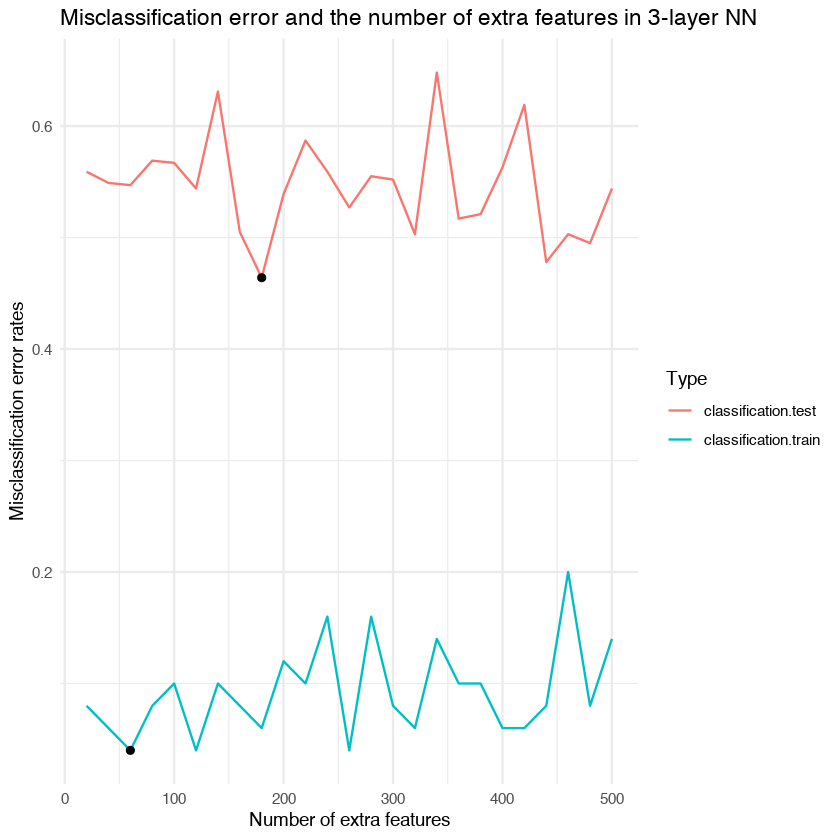

In [137]:
### compare misclassification errors and number of extra features in 3-layer NN 

ggplot(data = test.error.all.m[test.error.all.m$Type != 'reconstruction',]) +
geom_line(data = test.error.all.m[test.error.all.m$Type != 'reconstruction',], aes(x = k, y = Error, color = Type)) +
# geom_line(data = test.error.all, aes(x = k, y = classification.train, color = 'red')) +
# scale_color_manual(values = c('lightseagreen', 'red', ))+ 
geom_point(data = test.error.all[which.min(test.error.all$classification.test),], aes(x = k, y = classification.test)) +
geom_point(data = test.error.all[which.min(test.error.all$classification.train),], aes(x = k, y = classification.train)) +
ggtitle('Misclassification error and the number of extra features in 3-layer NN' ) + 
ylab('Misclassification error rates') + 
xlab('Number of extra features') + 
theme_minimal()